C:\Users\patri\AppData\Local\Temp\ipykernel_17700\3282731227.py:51: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  temp_raw['time'] = temp_raw.indexes['time'].to_datetimeindex()


Test MSE: 0.1154


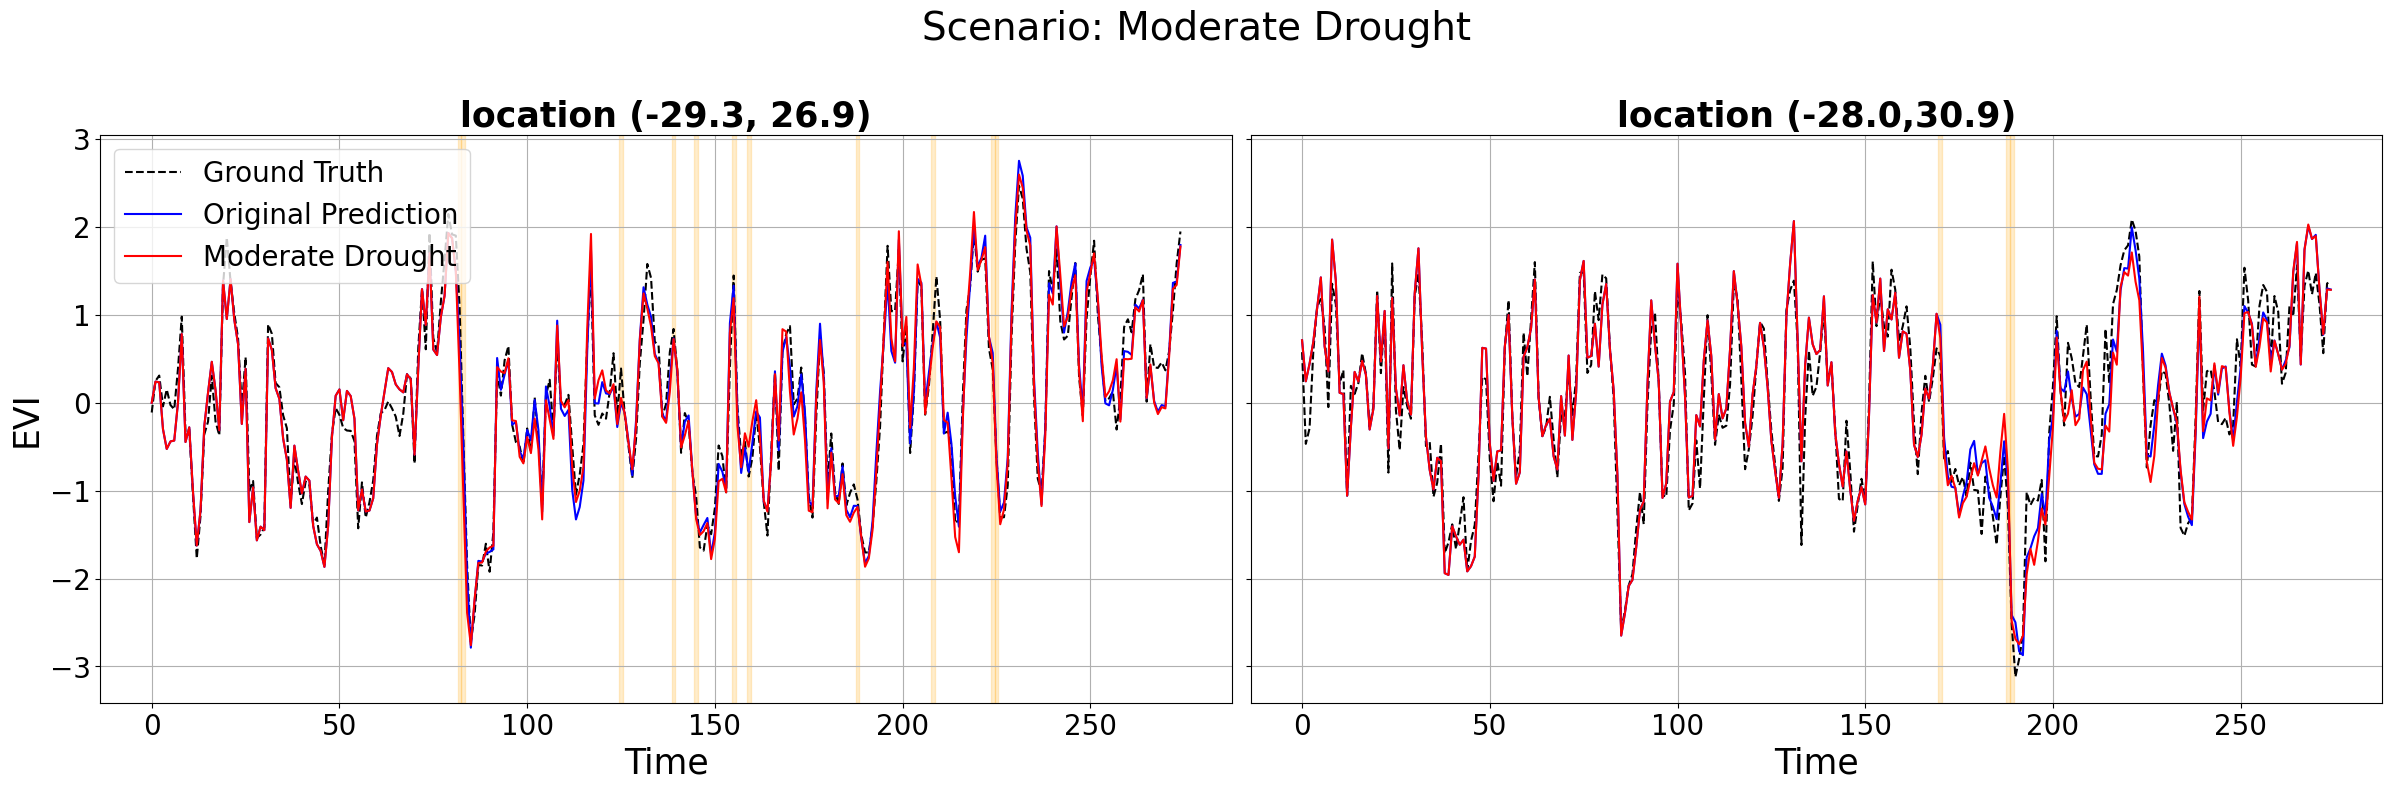

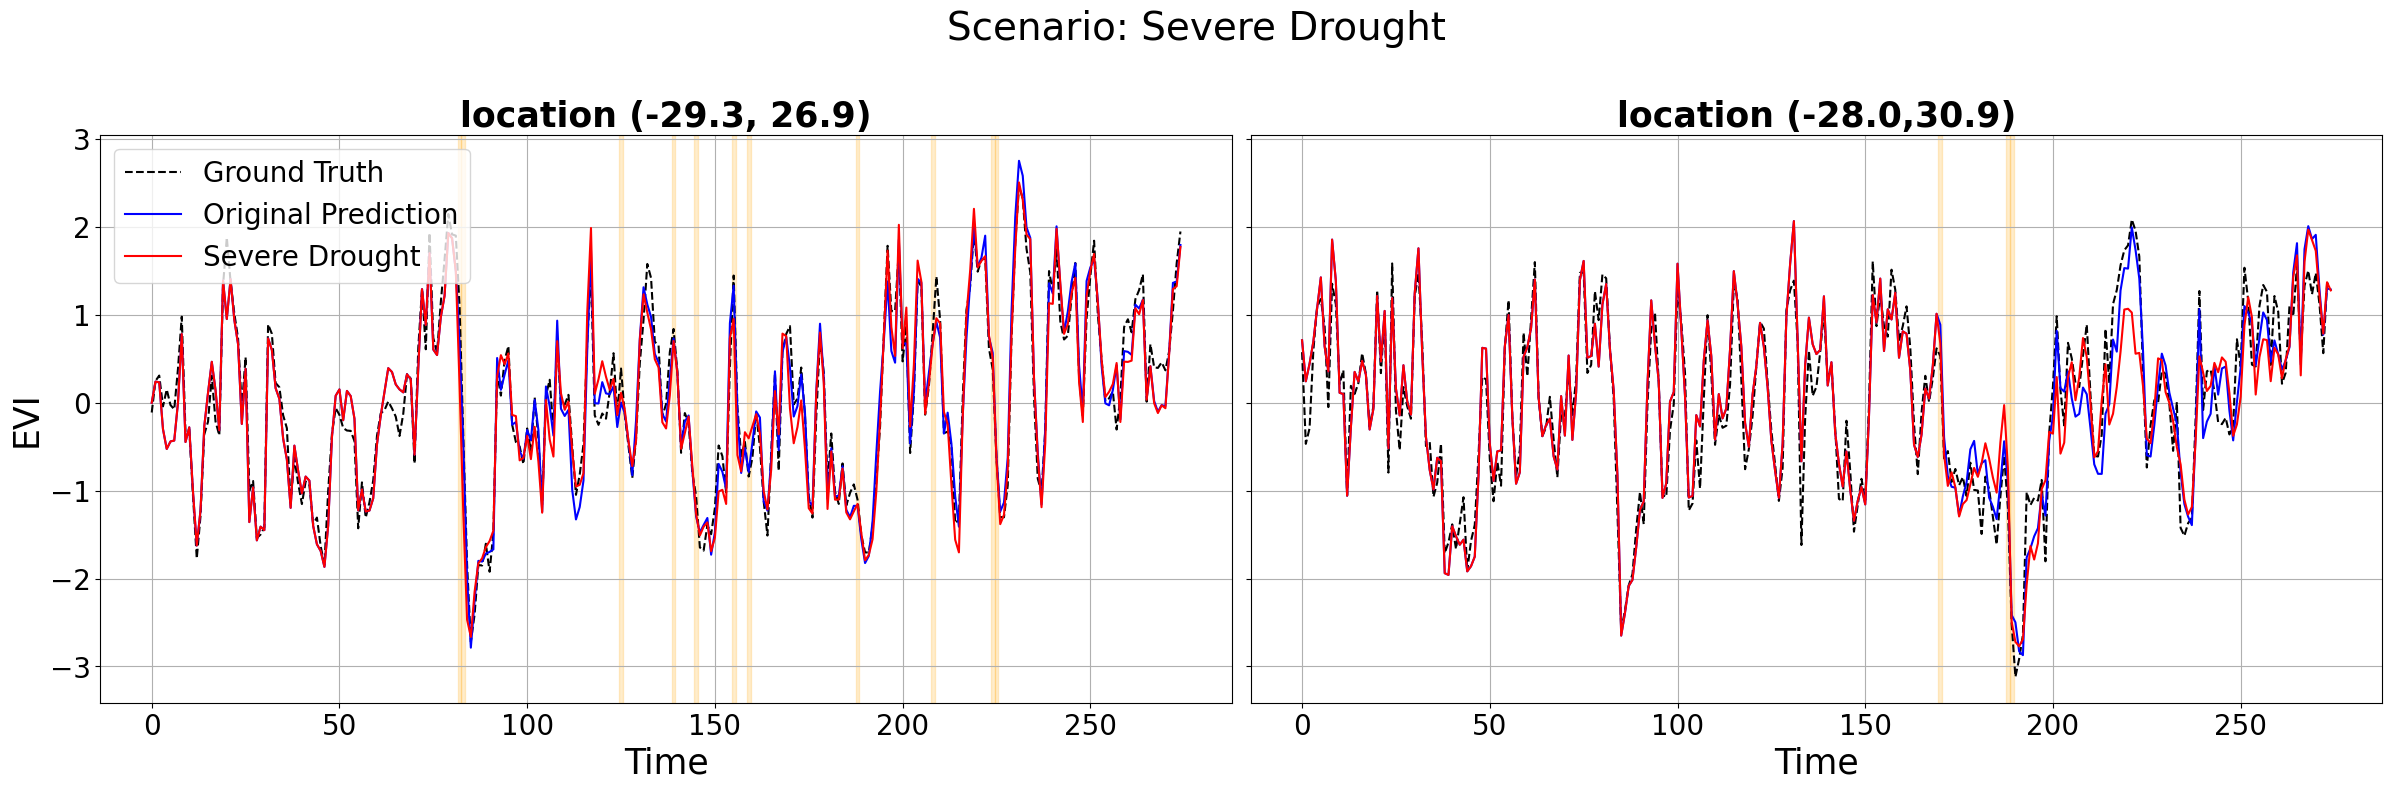

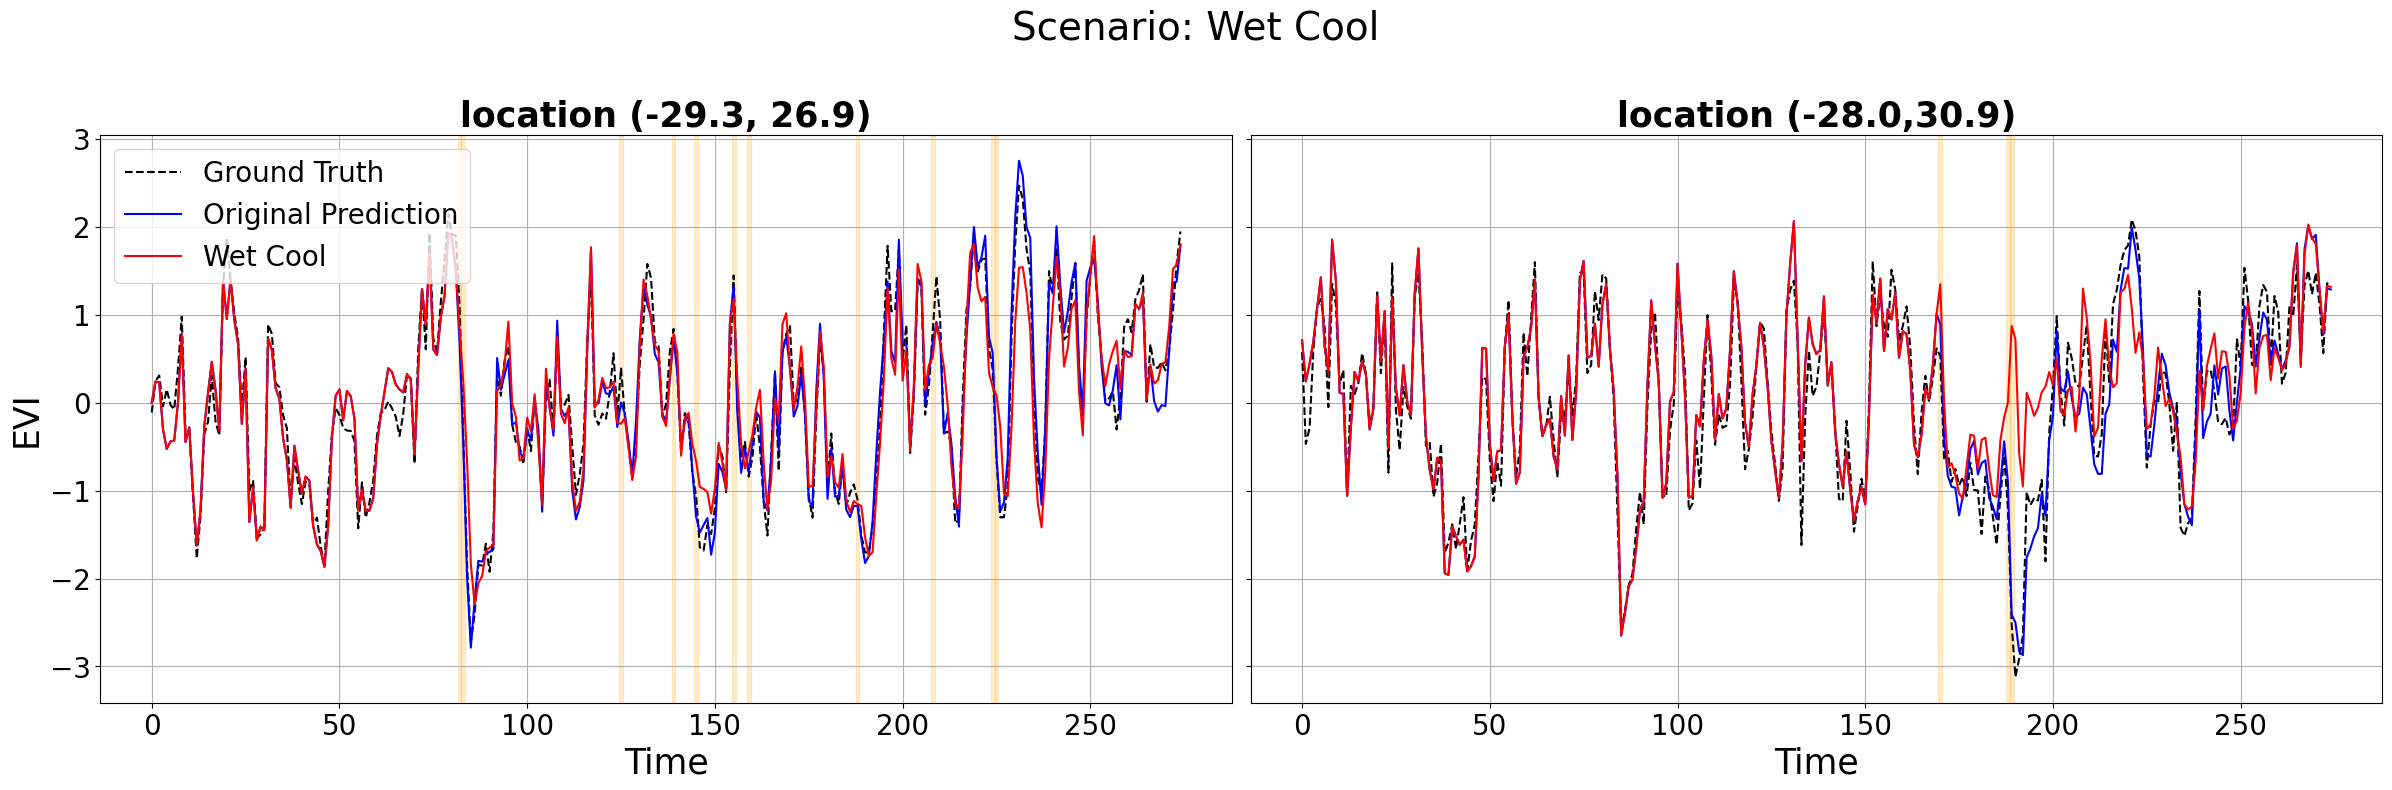

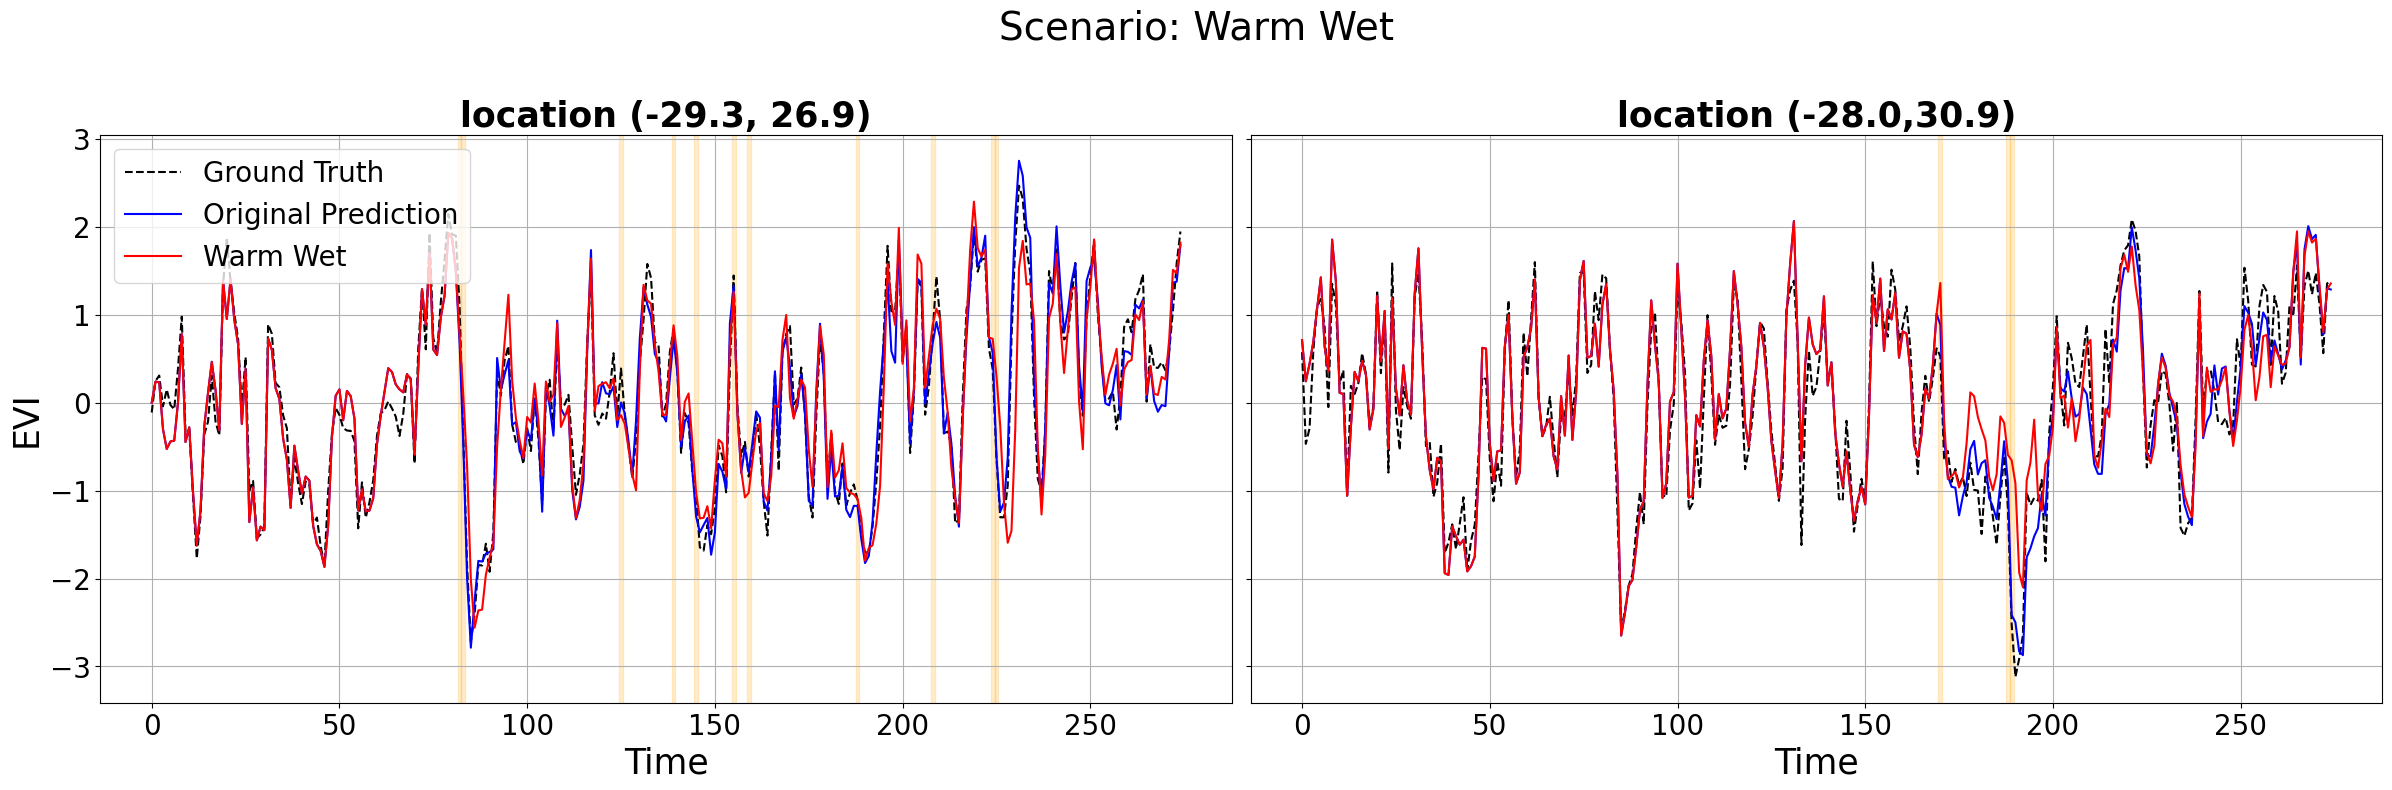

In [ ]:
import os
import xarray as xr
import cftime 
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import numpy as np
from model import PixelLSTM
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import torch.nn.functional as F
from sklearn.ensemble import RandomForestRegressor
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
import numpy as np
import torch
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Patch



precip_raw = xr.open_dataset('data/era5_total_precipitation_1950_2023_monthly_0_1_bil_regridded_s_africa_l.nc')
temp_raw = xr.open_dataset('data/era5_2m_temperature_1950_2023_monthly_0_1_remapnn_s_africa_l.nc', decode_times=False)
coords = torch.load("data/coords_test.npy", map_location='cpu', weights_only=False)

coords_subset = np.load("data/coords_r2_subset.npy") #where spei is estimated well!!

mask = np.load("data/good_spei_mask.npy")


# Processed versions
precip = precip_raw['tp']

# Fix temperature time using cftime and convert to datetime64
time_values = temp_raw['time'].values
units = temp_raw['time'].attrs['units']
calendar = temp_raw['time'].attrs.get('calendar', 'standard')
dates = cftime.num2date(time_values, units, calendar)
temp_raw['time'] = ('time', dates)
temp_raw['time'] = temp_raw.indexes['time'].to_datetimeindex()
temp = temp_raw['t2m']


# Clip all dynamic datasets to a common time range
def clip_to_common_dates(datasets, start='2000-02-01', end='2022-12-31'):
    return [ds.sel(time=slice(start, end)) for ds in datasets]


# Apply to relevant variables
dynamic_series = [precip, temp]
PREC, TEMP= clip_to_common_dates(dynamic_series)


PREC = xr.apply_ufunc(lambda x: np.log1p(x*10000),PREC)


temp_monthly_mean = TEMP.groupby('time.month').mean('time')
temp_monthly_std = TEMP.groupby('time.month').std('time')

prec_monthly_mean = PREC.groupby('time.month').mean('time')
prec_monthly_std = PREC.groupby('time.month').std('time')
# Load model pixel coordinates (shape: [5295, 2], with lat, lon)


# Get lat/lon values from your xarray monthly means (any xarray with 'lat' and 'lon')
lat_vals = prec_monthly_mean['lat'].values
lon_vals = prec_monthly_mean['lon'].values

# Map lat/lon coords to index in flat grid
lat_idx = np.searchsorted(lat_vals, coords[:, 0])
lon_idx = np.searchsorted(lon_vals, coords[:, 1])
flat_idx = lat_idx * len(lon_vals) + lon_idx  # convert to flat pixel index

# Stack xarray to flat (month, pixel) → shape: (12, 21901)
prec_mean_flat = prec_monthly_mean.stack(pixel=("lat", "lon")).transpose("month", "pixel").values
prec_std_flat = prec_monthly_std.stack(pixel=("lat", "lon")).transpose("month", "pixel").values
temp_mean_flat = temp_monthly_mean.stack(pixel=("lat", "lon")).transpose("month", "pixel").values
temp_std_flat = temp_monthly_std.stack(pixel=("lat", "lon")).transpose("month", "pixel").values

# Subset to match model pixels
prec_mean_by_month = prec_mean_flat[:, flat_idx]  # shape: (12, 5295)
prec_std_by_month  = prec_std_flat[:, flat_idx]
temp_mean_by_month = temp_mean_flat[:, flat_idx]
temp_std_by_month  = temp_std_flat[:, flat_idx]

prec_mean_by_month = torch.tensor(prec_mean_by_month, dtype=torch.float32)
prec_std_by_month = torch.tensor(prec_std_by_month, dtype=torch.float32)
temp_mean_by_month = torch.tensor(temp_mean_by_month, dtype=torch.float32)
temp_std_by_month = torch.tensor(temp_std_by_month, dtype=torch.float32)

  # Make sure model.py is in the same directory

# === Load your saved data ===
X_test = np.load("data/X_test.npy")              # Shape: (T, P, F)

#X_test = [spei3,spei1,prec,temp]


static_test = np.load("data/static_test.npy")    # Shape: (P, S)
y_test = np.load("data/y_test.npy")              # Shape: (T, P)

# === Preprocess ===
X_test = torch.tensor(X_test.transpose(1, 0, 2), dtype=torch.float32)  # (P, T, F)
static_test = torch.tensor(static_test, dtype=torch.float32)          # (P, S)
y_test = torch.tensor(y_test.transpose(1, 0), dtype=torch.float32)

# === Step 1: Define drought periods per pixel based on SPEI1 ===
def identify_drought_periods(X, spei1_index=1, threshold=-1.0, duration=3):
    P, T, F = X.shape
    drought_masks = torch.zeros((P, T), dtype=torch.bool)

    for i in range(P):
        spei_series = X[i, :, spei1_index].numpy()
        drought_flags = (spei_series < threshold).astype(int)
        convolved = np.convolve(drought_flags, np.ones(duration, dtype=int), mode='valid') >= duration
        convolved = np.pad(convolved, (0, T - len(convolved)))  # pad to match time length
        drought_masks[i] = torch.tensor(convolved)

    return drought_masks  # Shape: (P, T)





drought_mask = identify_drought_periods(X_test, spei1_index=1, threshold=-1.0, duration=3)

start_date = datetime.strptime("2000-02-01", "%Y-%m-%d")
months = np.array([(start_date + timedelta(days=30 * i)).month for i in range(275)])  # shape (T,)

def apply_realistic_perturbations(X_std, drought_mask, months,
                                  prec_mean, prec_std, temp_mean, temp_std,
                                  prec_shift_std=0.0, temp_shift_std=0.0,
                                  prec_idx=2, temp_idx=3,
                                  verbose=False, check_every=20):
    """
    Apply counterfactual perturbations to standardized PREC and TEMP during drought periods.
    Clamping is removed — precipitation can go to zero or near-zero naturally.
    A soft warning is added if log_prec drops below 0.
    """
    X = X_std.clone()
    P, T, _ = X.shape

    for t in range(T):
        month = months[t] - 1
        mask = drought_mask[:, t]

        if not mask.any():
            continue

        if verbose and t % check_every == 0:
            print(f"\n[DEBUG] t={t}, month={month+1}, affected pixels={mask.sum().item()}")

        # === PRECIPITATION ===
        if prec_shift_std != 0.0:
            std_before = X[mask, t, prec_idx].clone()
            X[mask, t, prec_idx] += prec_shift_std

            prec_std_t = prec_std[month][mask]
            prec_mean_t = prec_mean[month][mask]

            log_prec = X[mask, t, prec_idx] * prec_std_t + prec_mean_t
            prec_real = torch.expm1(log_prec) / 10000.0  # m/month
            prec_real = torch.clamp(prec_real, min=0.0)

            if verbose and t % check_every == 0:
                print(f"  [PREC] Real precip after shift (min): {prec_real.min().item():.6f}")

            

            # Re-standardize
            log_prec_new = torch.log1p(prec_real * 10000.0)
            X[mask, t, prec_idx] = (log_prec_new - prec_mean_t) / prec_std_t

            if verbose and t % check_every == 0:
                print(f"  [PREC] Real precip after shift (mean): {prec_real.mean().item():.6f} m/month")
                print(f"  [PREC] Std before shift: {std_before.mean().item():.2f}")
                print(f"  [PREC] Std after re-standardize: {X[mask, t, prec_idx].mean().item():.2f}")

        # === TEMPERATURE ===
        if temp_shift_std != 0.0:
            std_before = X[mask, t, temp_idx].clone()
            X[mask, t, temp_idx] += temp_shift_std

            temp_std_t = temp_std[month][mask]
            temp_mean_t = temp_mean[month][mask]

            temp_real_before = std_before * temp_std_t + temp_mean_t
            temp_real_after = X[mask, t, temp_idx] * temp_std_t + temp_mean_t

            if verbose and t % check_every == 0:
                print(f"  [TEMP] Before shift (real mean): {temp_real_before.mean().item():.2f} K")
                print(f"  [TEMP] After shift (real mean): {temp_real_after.mean().item():.2f} K")

    return X




min_evi_per_pixel = torch.min(y_test, dim=1).values  # Shape: (P,)
def count_droughts_per_pixel(drought_mask):
    """
    Count the number of distinct drought events (e.g., 3+ consecutive months of SPEI1 < threshold)
    per pixel.
    
    Parameters:
        drought_mask (torch.Tensor): Boolean tensor of shape (P, T), where True means the
                                     pixel is in drought at that time step.

    Returns:
        torch.Tensor: Drought count per pixel, shape (P,)
    """
    P, T = drought_mask.shape
    drought_counts = torch.zeros(P, dtype=torch.int32)

    for i in range(P):
        in_drought = False
        count = 0
        for t in range(T):
            if drought_mask[i, t]:
                if not in_drought:
                    count += 1
                    in_drought = True
            else:
                in_drought = False
        drought_counts[i] = count

    return drought_counts

drought_counts = count_droughts_per_pixel(drought_mask)  # Shape: (P,)


def replace_spei_during_drought_linear(X, drought_mask, static_test, start_date=datetime(2000, 2, 1)):
    """
    Replaces SPEI1 during drought periods using a per-pixel linear regression on
    standardized PREC, TEMP, month (one-hot), and static features.
    SPEI3 is recalculated only during drought periods and up to 3 months after.

    Args:
        X: torch.Tensor of shape (P, T, F)
        drought_mask: torch.BoolTensor of shape (P, T)
        static_test: np.ndarray of shape (P, S)
        start_date: datetime object representing the start of time series

    Returns:
        torch.Tensor: updated X with SPEI1 and SPEI3 modifications
    """
    X_np = X.clone().numpy()              
    drought_np = drought_mask.numpy()     
    P, T, F = X_np.shape
    S = static_test.shape[1]
    X_mod = X_np.copy()

    # Prepare month one-hot encodings
    months = np.array([(start_date + relativedelta(months=i)).month for i in range(T)])
    month_onehot = np.eye(12)[months - 1]  # (T, 12)

    for p in range(P):
        z_prec = X_np[p, :, 2]
        z_temp = X_np[p, :, 3]
        spei1 = X_np[p, :, 1]
        static_feat = static_test[p]  
        static_repeated = np.tile(static_feat, (T, 1))  

        # Design matrix
        X_features = np.concatenate([
            z_prec[:, None],
            z_temp[:, None],
            month_onehot,
            static_repeated
        ], axis=1)

        valid_mask = ~np.isnan(spei1) & ~np.isnan(z_prec) & ~np.isnan(z_temp)
        if valid_mask.sum() < 10:
            continue

        model = LinearRegression().fit(X_features[valid_mask], spei1[valid_mask])
        drought_idx = drought_np[p, :]

        if not np.any(drought_idx):
            continue

        # === Step 1: Update SPEI1 only during drought ===
        X_mod[p, drought_idx, 1] = model.predict(X_features[drought_idx])

        # === Step 2: Identify SPEI3 timesteps to update ===
        affected = np.zeros(T, dtype=bool)
        drought_indices = np.where(drought_idx)[0]

        for idx in drought_indices:
            affected[idx:idx+4] = True  # this includes the drought month + next 3

        affected = np.where(affected)[0]
        affected = affected[affected >= 2]  # SPEI3 starts at t=2 (needs 3-month window)

        # === Step 3: Recalculate SPEI3 only at affected times ===
        new_spei1 = X_mod[p, :, 1]
        new_spei3 = X_mod[p, :, 0].copy()  # start with original SPEI3

        for t in affected:
            window = new_spei1[t - 2:t + 1]
            if np.all(~np.isnan(window)):
                new_spei3[t] = np.mean(window)

        X_mod[p, :, 0] = new_spei3

    return torch.tensor(X_mod, dtype=torch.float32)

#plot function 

def plot_prediction_comparison(
    pixel_idx, predictions, predictions_perturbed, y_true, drought_mask, title_prefix=""
):
    """
    Plot original vs. perturbed predictions and true target for a given pixel,
    with drought periods shaded in the background.
    """
    pred = predictions[pixel_idx].numpy()
    perturbed = predictions_perturbed[pixel_idx].numpy()
    truth = y_true[pixel_idx].numpy()
    drought = drought_mask[pixel_idx].numpy()
    T = len(pred)

    plt.figure(figsize=(18,7 ))

    # Plot the time series
    plt.plot(range(T), truth, label="Ground Truth", linestyle='--', color='black')
    plt.plot(range(T), pred, label="Original Prediction", color='red')
    plt.plot(range(T), perturbed, label="Perturbed Prediction", color='blue')

    # Highlight drought periods as vertical shaded regions
    for t in range(T):
        if drought[t]:
            plt.axvspan(t - 0.5, t + 0.5,color='orange', alpha=0.2)

    drought_patch = Patch(facecolor='orange', alpha=0.2, label='Drought Period')

    # Formatting
    plt.title(f"{title_prefix} at (-29.3,  26.9)", fontsize=22,fontweight ='bold',pad = 20)
    plt.xlabel("Time Step", fontsize=18)
    plt.ylabel("EVI", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(handles=[drought_patch] + plt.gca().get_legend_handles_labels()[0], fontsize=20)
    plt.grid(True)
    plt.tight_layout()

    #plt.savefig("wet_cool_scenario_small.png", dpi=600)
    plt.show()

# === Define model architecture (must match training) ===
model = PixelLSTM(
    input_size=X_test.shape[2],
    static_size=static_test.shape[1],
    hidden_size=256,
    num_layers=3,
    dropout=0.3987832655685518
)

# === Load the weights ===
checkpoint = torch.load("data/model_checkpoint.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])  # ✅ just the model weights


model.eval()

# === Run inference ===
with torch.no_grad():
    predictions = model(X_test, static_test)  # Shape: (P, T)

# === Convert to NumPy if needed ===
predictions_np = predictions.numpy()

# === Evaluate (optional) ===




mse = torch.nn.functional.mse_loss(predictions, y_test)

print(f"Test MSE: {mse.item():.4f}")



# Compute per-pixel MSE change during drought
def get_pixels_by_mse_change(y_true, y_pred_base, y_pred_perturbed, drought_mask, top_k=10, reverse=True):
    """
    Computes per-pixel MSE difference between base and perturbed predictions during drought.
    
    Args:
        y_true (Tensor): Ground truth, shape (P, T)
        y_pred_base (Tensor): Original predictions, shape (P, T)
        y_pred_perturbed (Tensor): Perturbed predictions, shape (P, T)
        drought_mask (Tensor): Boolean mask, shape (P, T)
        top_k (int): Number of pixels to return
        reverse (bool): If True, return highest MSE increases. If False, lowest.
    
    Returns:
        List of pixel indices sorted by ΔMSE
    """
    P, T = y_true.shape
    mse_diffs = torch.zeros(P)

    for p in range(P):
        mask = drought_mask[p]
        if mask.sum() == 0:
            mse_diffs[p] = float('-inf') if reverse else float('inf')
            continue

        base = y_pred_base[p][mask]
        pert = y_pred_perturbed[p][mask]
        target = y_true[p][mask]

        mse_base = F.mse_loss(base, target)
        mse_pert = F.mse_loss(pert, target)
        mse_diffs[p] = mse_pert - mse_base

    # Get top K indices
    sorted_indices = torch.argsort(mse_diffs, descending=reverse)
    return sorted_indices[:top_k].tolist(), mse_diffs





scenarios = [
    {"name": "Moderate Drought", "prec_shift_std": -1, "temp_shift_std": 1},
    {"name": "Severe Drought", "prec_shift_std": -1.5, "temp_shift_std": 1.5},
    {"name": "Wet Cool", "prec_shift_std": 2, "temp_shift_std": -2},
    {"name": "Warm Wet", "prec_shift_std": 2, "temp_shift_std": 2}

]

results = {}

for scenario in scenarios:
    name = scenario["name"]

    # Apply perturbation
    Xperturbed = apply_realistic_perturbations(
        X_std=X_test,
        drought_mask=drought_mask,
        months=months,
        prec_mean=prec_mean_by_month,
        prec_std=prec_std_by_month,
        temp_mean=temp_mean_by_month,
        temp_std=temp_std_by_month,
        prec_shift_std=scenario["prec_shift_std"],
        temp_shift_std=scenario["temp_shift_std"]
    )


    X_perturbed = replace_spei_during_drought_linear(Xperturbed, drought_mask,static_test.numpy() if isinstance(static_test, torch.Tensor) else static_test)
    # Run inference
    with torch.no_grad():
        preds_perturbed = model(X_perturbed, static_test)

    # Calculate mean delta during drought
    delta = preds_perturbed - predictions
    mean_delta = delta[drought_mask].mean().item() if drought_mask.any() else 0.0

    # Store for later
    results[name] = {
        "delta_mean": mean_delta,
        "preds": preds_perturbed
    }

    # === Plot for multiple pixels ===
    T = predictions.shape[1]



    pixels_to_plot = [2146, 1395]
    #(-29.3, 26.9)  ,  (-28.0, 30.9)
    # Get top 5 pixels with biggest MSE change under this scenario
    '''
    pixels_to_plot, mse_deltas = get_pixels_by_mse_change(
        y_true=y_test,
        y_pred_base=predictions,
        y_pred_perturbed=preds_perturbed,
        drought_mask=drought_mask,
        top_k=3,  # you can change this
        reverse=True  # True = biggest change
    )

    print(f"Top ΔMSE pixels for {name}: {pixels_to_plot}")
    '''



    n_pixels = len(pixels_to_plot)
    
    fig, axes = plt.subplots(1, n_pixels, figsize=(12 * n_pixels, 8), sharey=True)

    for i, pix in enumerate(pixels_to_plot):
        ax = axes[i] if n_pixels > 1 else axes
        truth = y_test[pix].numpy()
        base = predictions[pix].numpy()
        pert = preds_perturbed[pix].numpy()
        drought = drought_mask[pix].numpy()

        ax.plot(truth, label="Ground Truth", linestyle='--', color='black')
        ax.plot(base, label="Original Prediction", color='blue')
        ax.plot(pert, label=name, color='red')

        for t in range(T):
            if drought[t]:
                ax.axvspan(t - 0.5, t + 0.5,color='orange', alpha=0.2)

        drought_patch = Patch(facecolor='orange', alpha=0.2, label='Drought Period')


        if pix == 2146:
            ax.set_title("location (-29.3, 26.9)",fontsize = 25, fontweight = 'bold')
        else:
            ax.set_title("location (-28.0,30.9)",fontsize=25,fontweight = 'bold')
        ax.set_xlabel("Time",fontsize = 25)
        if i == 0:
            ax.set_ylabel("EVI",fontsize = 25)
            ax.legend(loc="upper left",fontsize = 20) # ✅ Only show legend on the first axis
        ax.grid(True)

        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

    fig.suptitle(f"Scenario: {name}", fontsize=28)
    fig.tight_layout(pad=1.0,rect=[0, 0, 1, 0.95])
    fig.savefig(f"{name.replace(' ', '_')}_timeseries.png", dpi=300)

    plt.show()


C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


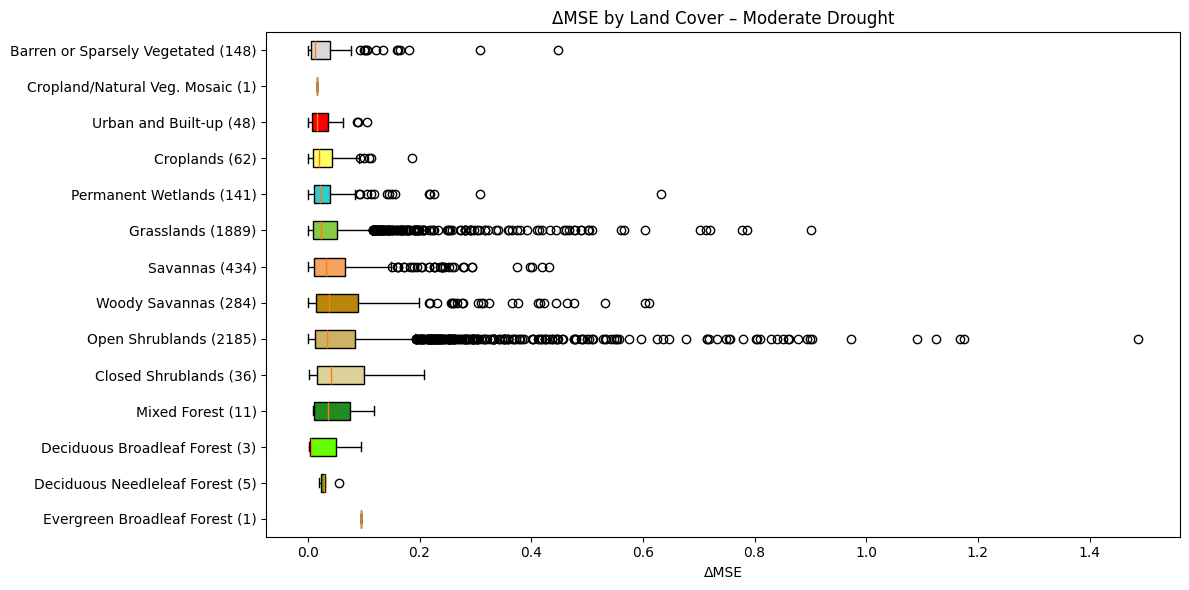

correlations of MSE change with Static Features. Scenario  Moderate Drought
WTD: -0.017
Sand: -0.010
Elevation: 0.087
prev_evi: -0.022
droughts: 0.111
min_evi: -0.023


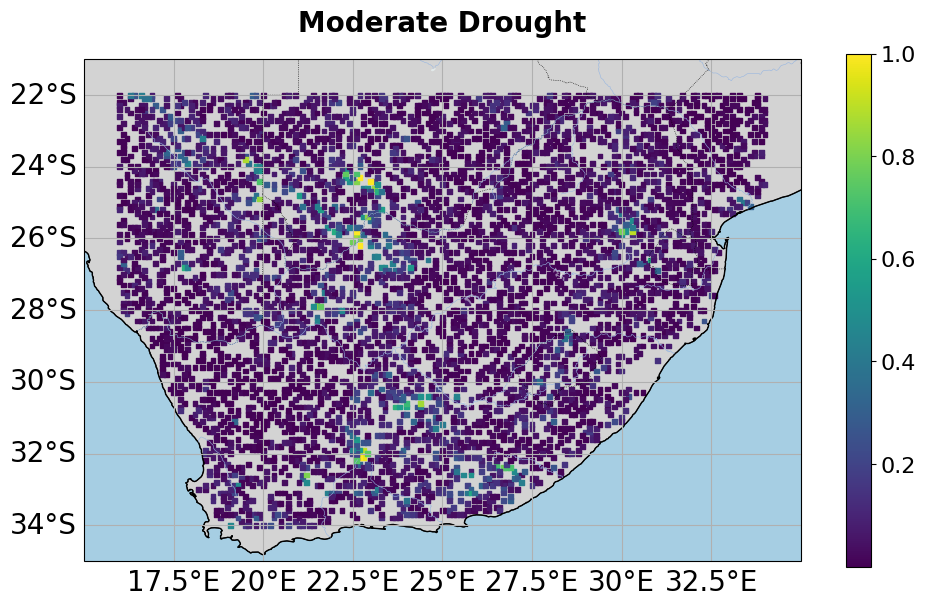

correlations of MSE change with Static Features. Scenario  Moderate Drought
WTD: 0.057
Sand: -0.085
Elevation: 0.043
prev_evi: -0.068
droughts: 0.116
min_evi: 0.020


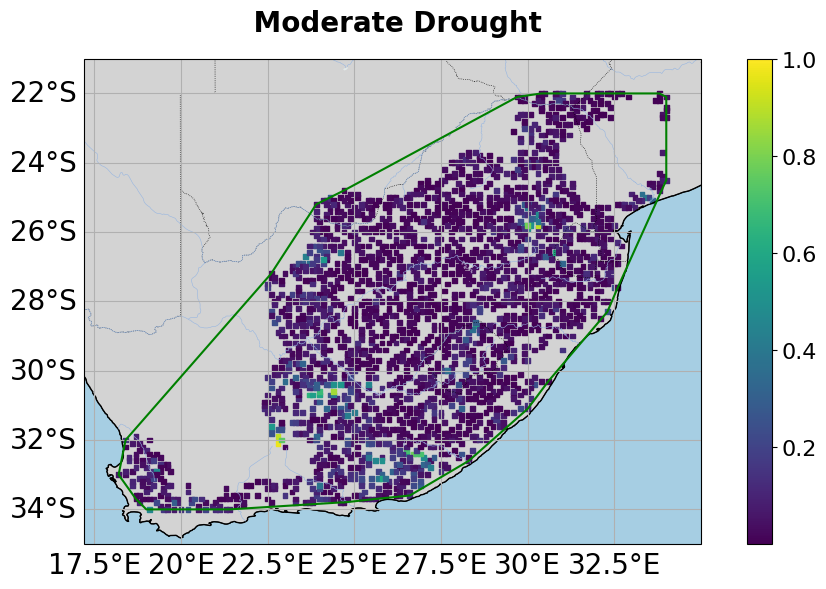

C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


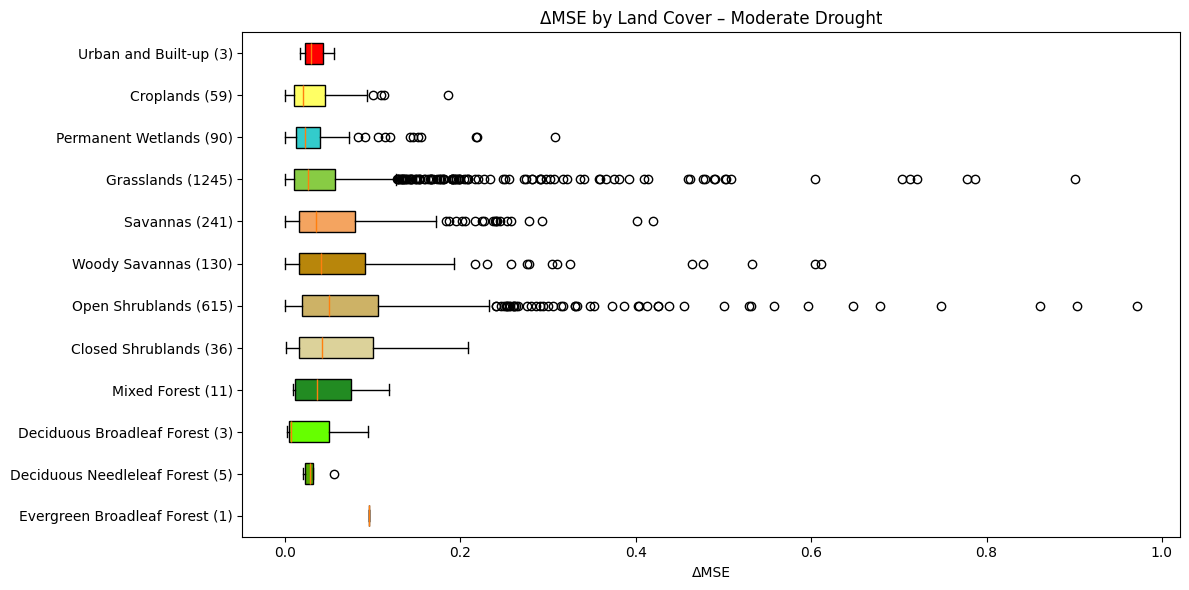

C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


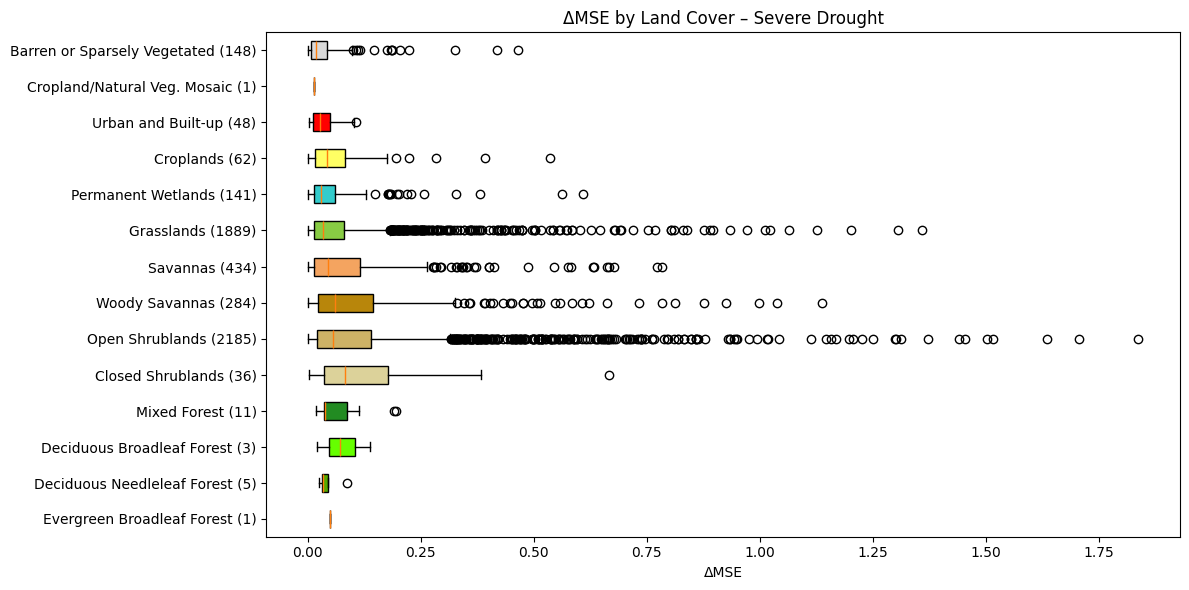

correlations of MSE change with Static Features. Scenario  Severe Drought
WTD: -0.014
Sand: -0.008
Elevation: 0.121
prev_evi: -0.024
droughts: 0.141
min_evi: -0.040


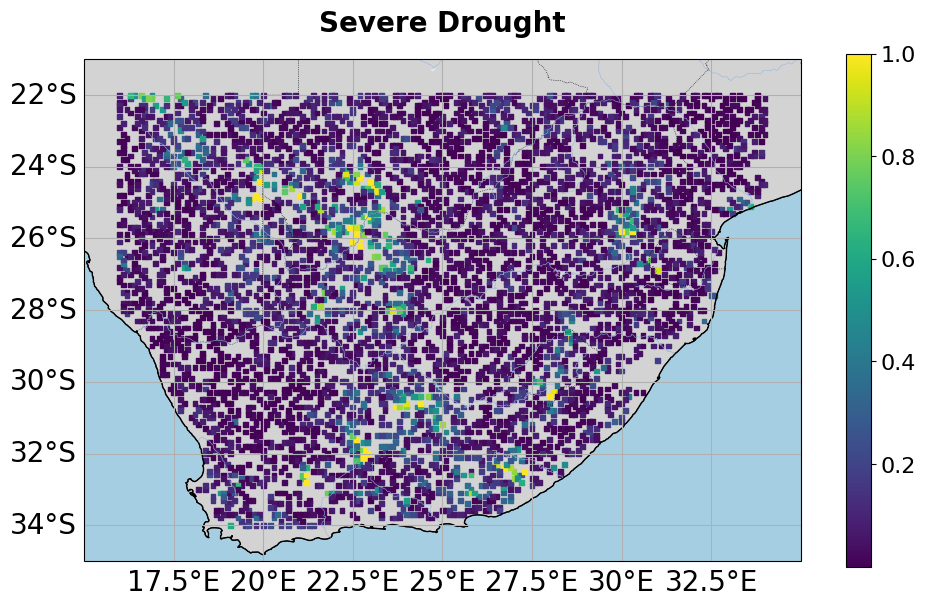

correlations of MSE change with Static Features. Scenario  Severe Drought
WTD: 0.080
Sand: -0.080
Elevation: 0.087
prev_evi: -0.072
droughts: 0.158
min_evi: 0.006


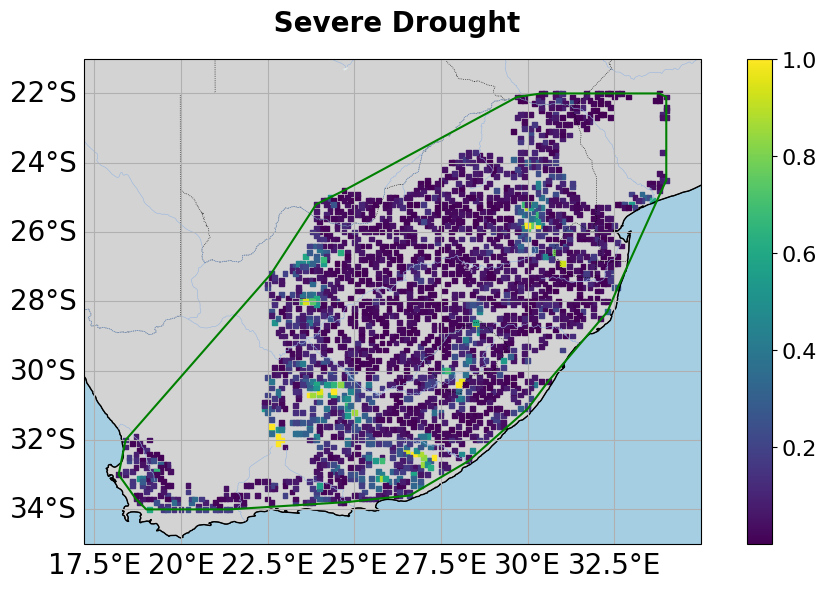

C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


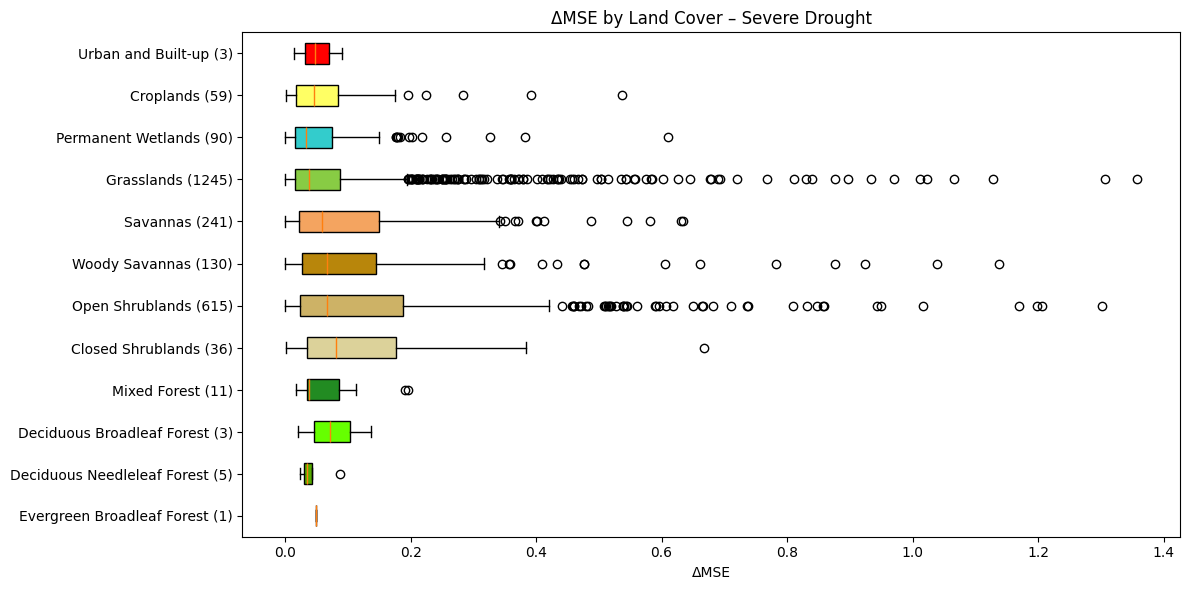

C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


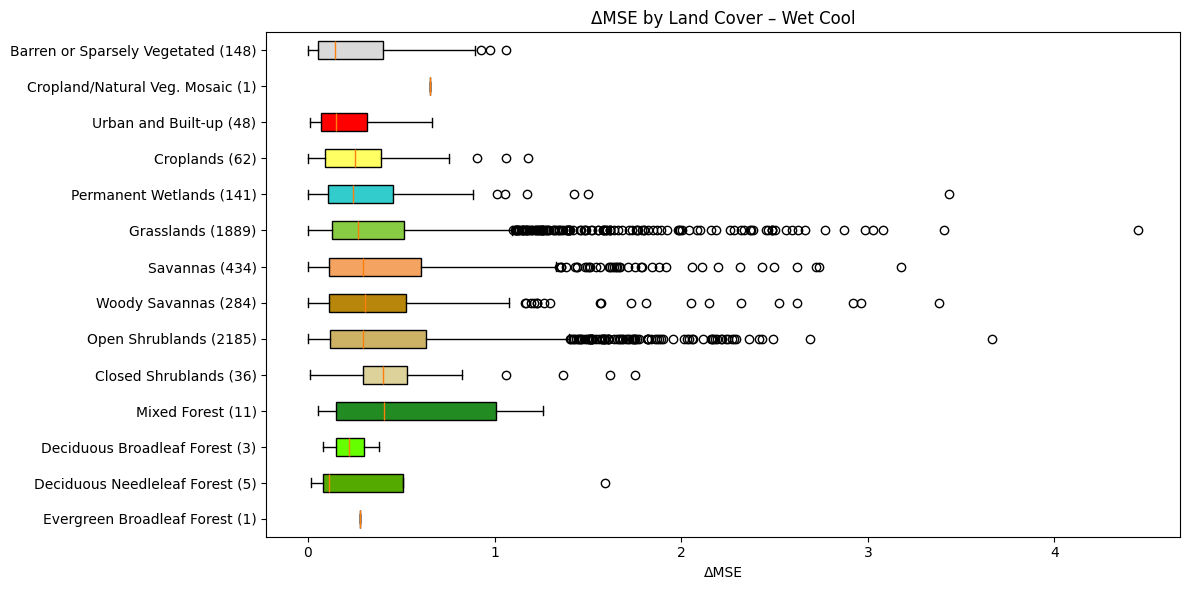

correlations of MSE change with Static Features. Scenario  Wet Cool
WTD: 0.009
Sand: -0.046
Elevation: -0.043
prev_evi: 0.044
droughts: 0.021
min_evi: -0.114


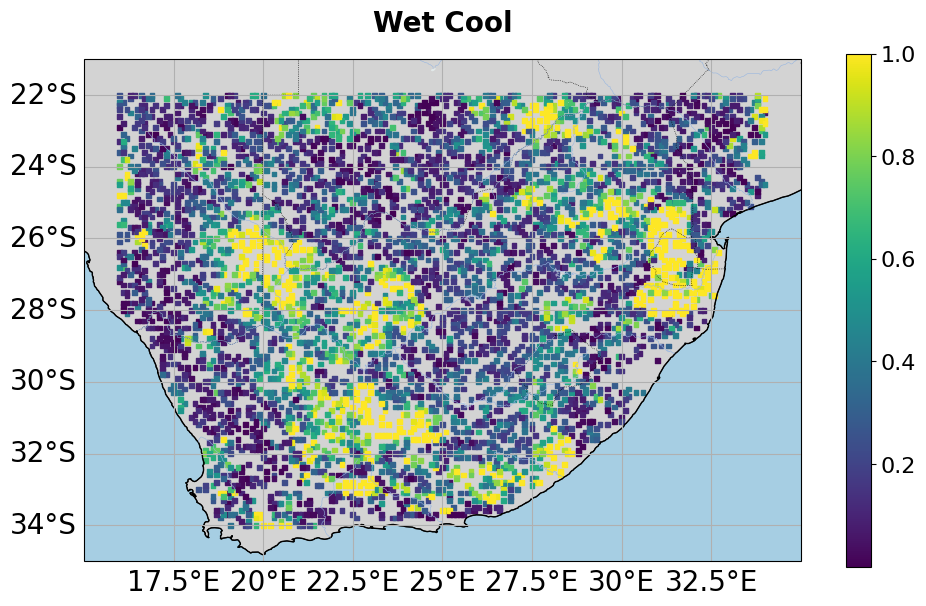

correlations of MSE change with Static Features. Scenario  Wet Cool
WTD: 0.022
Sand: -0.070
Elevation: -0.132
prev_evi: 0.005
droughts: -0.091
min_evi: -0.150


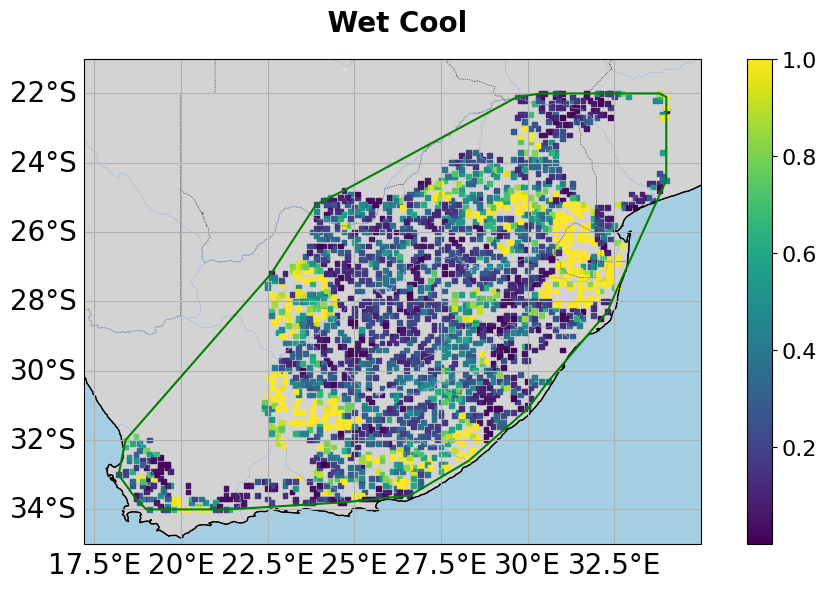

C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


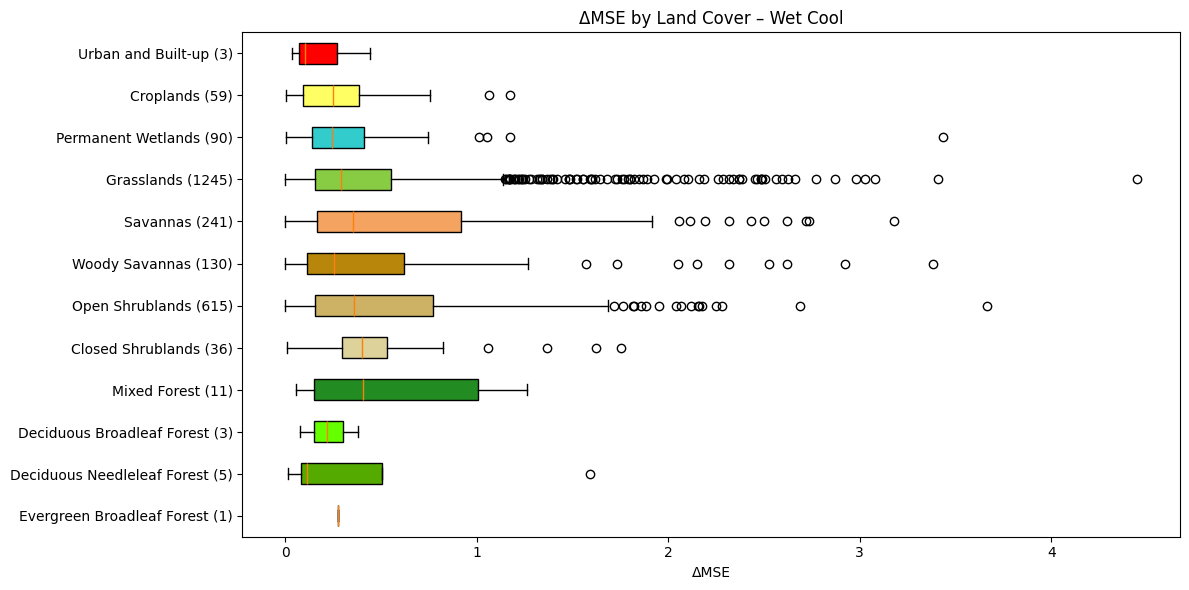

C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


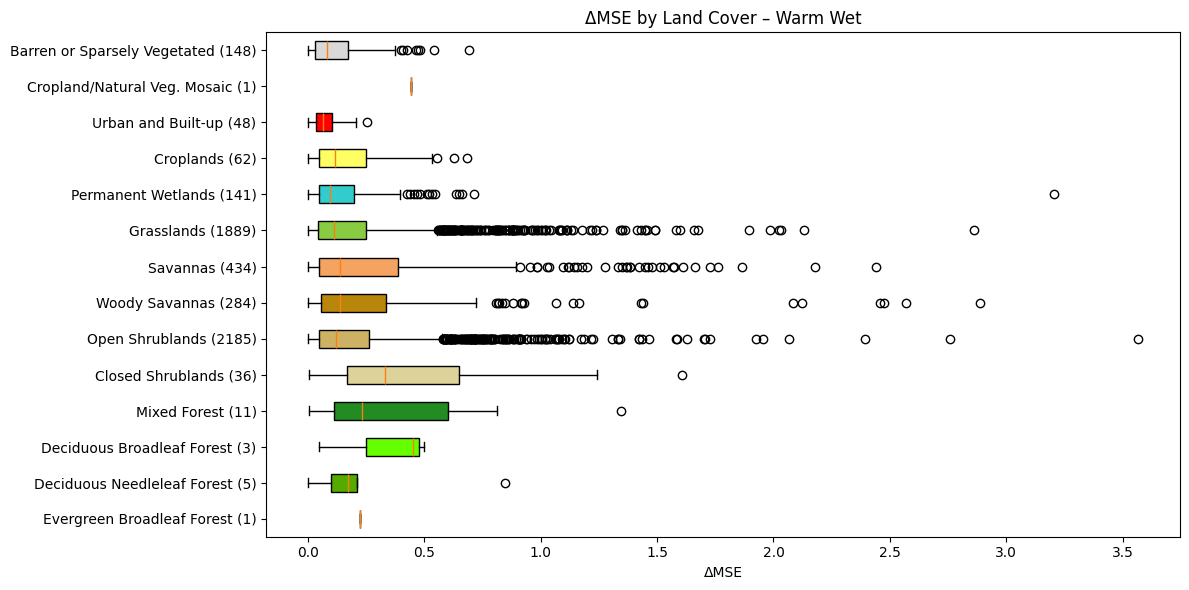

correlations of MSE change with Static Features. Scenario  Warm Wet
WTD: -0.014
Sand: -0.093
Elevation: -0.073
prev_evi: -0.069
droughts: -0.051
min_evi: -0.214


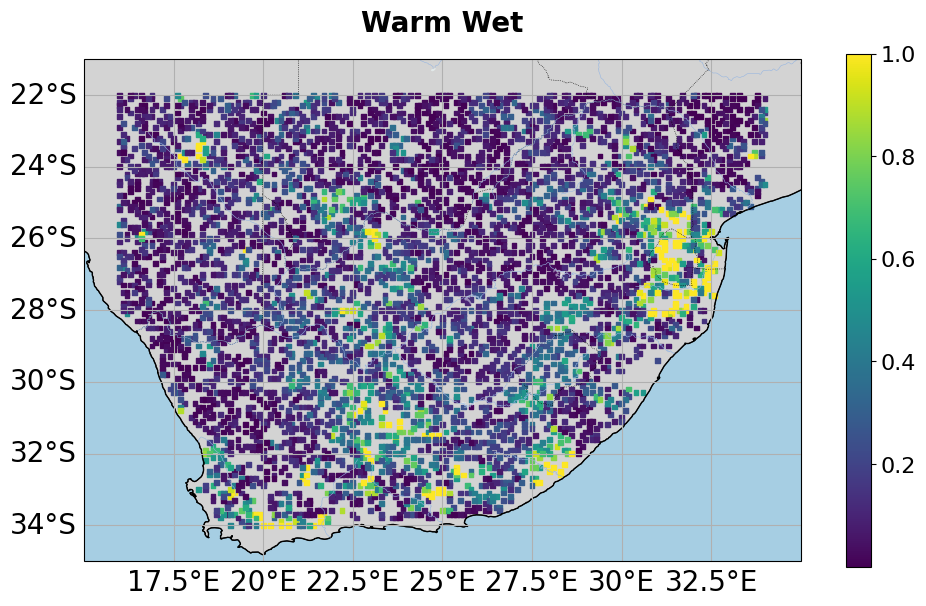

correlations of MSE change with Static Features. Scenario  Warm Wet
WTD: 0.006
Sand: -0.119
Elevation: -0.210
prev_evi: -0.043
droughts: -0.097
min_evi: -0.170


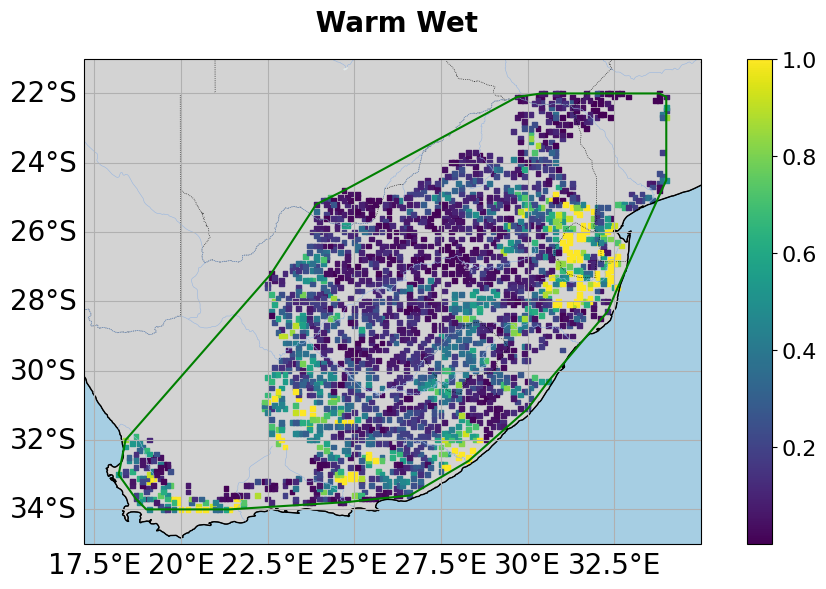

C:\Users\patri\AppData\Local\Temp\ipykernel_17700\2445275583.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)


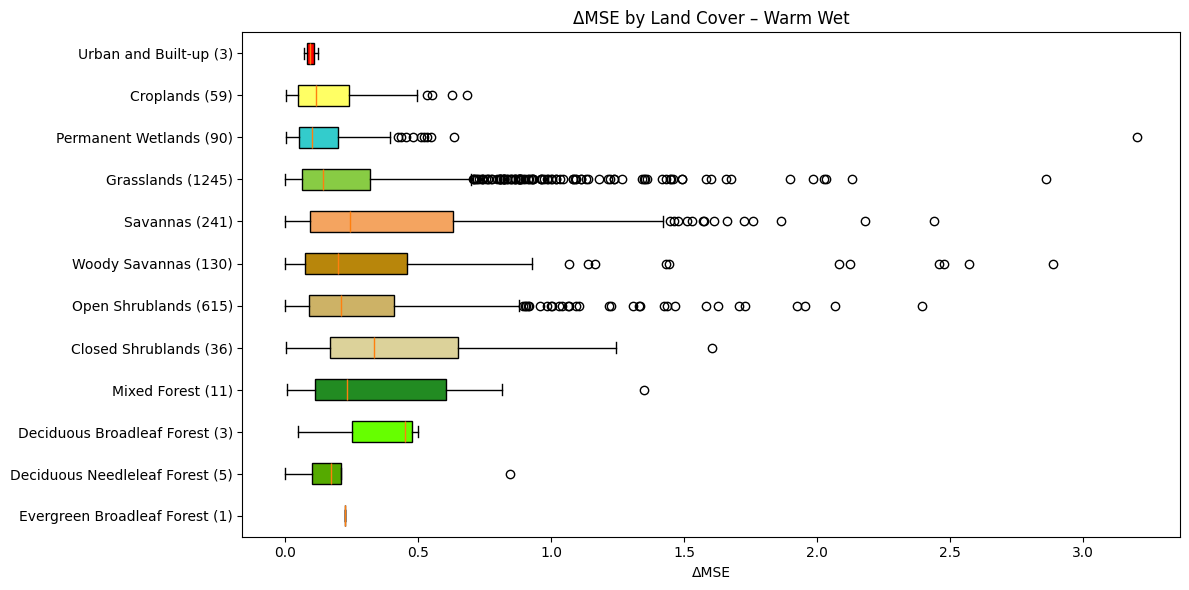

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np


landcover = xr.open_dataset(os.path.join(DATA_DIR, "landcover_MODIS_006_MCD12Q1_yearly__2001_2020_0_1_degree_regrid_s_africa_l.nc"))
landcover_large = landcover

lc_classes = {
    1:  ("Evergreen Needleleaf Forest", "#005500"),
    2:  ("Evergreen Broadleaf Forest", "#007f00"),
    3:  ("Deciduous Needleleaf Forest", "#55aa00"),
    4:  ("Deciduous Broadleaf Forest", "#66ff00"),
    5:  ("Mixed Forest", "#228b22"),
    6:  ("Closed Shrublands", "#dcd29a"),
    7:  ("Open Shrublands", "#cdb266"),
    8:  ("Woody Savannas", "#b8860b"),
    9:  ("Savannas", "#f4a460"),
    10: ("Grasslands", "#88cc44"),
    11: ("Permanent Wetlands", "#33cccc"),
    12: ("Croplands", "#ffff64"),
    13: ("Urban and Built-up", "#ff0000"),
    14: ("Cropland/Natural Veg. Mosaic", "#bfbf00"),
    15: ("Snow and Ice", "#ffffff"),
    16: ("Barren or Sparsely Vegetated", "#d9d9d9"),
    17: ("Water Bodies", "#0000ff"),
    255: ("Unclassified", "#000000")  # optional
}

lc_clean = landcover_large['LC_Type1'].astype('uint8')
lc_plot = lc_clean.isel(time=19)

#SOME FUNCTIONS
from scipy.spatial import ConvexHull
from alphashape import alphashape
from shapely.geometry import Polygon


def compute_mse_difference(y_true, y_base, y_cf, drought_mask):
    """
    Computes per-pixel MSE change between base and counterfactual predictions during drought.
    Returns tensor of shape (P,)
    """
    P, T = y_true.shape
    mse_diff = torch.zeros(P)

    for p in range(P):
        mask = drought_mask[p]
        if mask.sum() == 0:
            mse_diff[p] = torch.nan
            continue

        base_mse = F.mse_loss(y_base[p][mask], y_true[p][mask])
        cf_mse = F.mse_loss(y_cf[p][mask], y_true[p][mask])
        mse_diff[p] = abs(cf_mse - base_mse)

    return mse_diff


def plot_mse_map(mse_diff, coords, title, cmap='viridis', vmin=None, vmax=None,highlight_region = False,alpha_value = 0.1,filename='file'):
    """
    Plots a spatial map of per-pixel MSE difference using Cartopy.

    Args:
        mse_diff (Tensor): shape (P,)
        coords (ndarray): shape (P, 2), [lat, lon]
        title (str): Title of the plot
        cmap (str): Colormap
        vmin/vmax: Color limits
    """
    lat = coords[:, 0]
    lon = coords[:, 1]
    data = mse_diff.cpu().numpy()

    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon.min()-1, lon.max()+1, lat.min()-1, lat.max()+1], crs=ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='#a6cee3')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, facecolor='azure', alpha=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.4)




    gl = ax.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

    gl.top_labels = False
    gl.right_labels = False


    sc = ax.scatter(lon, lat, c=data, cmap=cmap, s=12, marker = 's',vmin=vmin, vmax=vmax)


    if highlight_region and len(coords) >= 4:
        points = np.column_stack((lon, lat))
        shape = alphashape(points, alpha_value)

        if isinstance(shape, Polygon):
            x, y = shape.exterior.xy
            ax.plot(x, y, color='green', linewidth=1.5, transform=ccrs.PlateCarree(), label="Region Boundary")

    # Optional: highlight a specific pixel (e.g., [-29.3, 26.9])
    highlight_lat = -29.3
    highlight_lon = 26.9
    #ax.scatter(highlight_lon, highlight_lat, color='orange', edgecolor='black', s=100, marker='o', zorder=5, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
    #cbar.set_label("MSE Change", fontsize=20)
    cbar.ax.tick_params(labelsize=16)  # Tick label font size

    plt.title(title,fontsize=20,fontweight = 'bold',pad = 20)

    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=600)
    plt.show()


def compute_static_correlations(static_test, mse_diff, feature_names=None):
    """
    Computes Pearson correlation between mse_diff and first 3 static features.

    Args:
        static_test (Tensor): shape (P, S), e.g. [5295, 4]
        mse_diff (Tensor): shape (P,)
        feature_names (list): optional names for static features

    Returns:
        Dict of correlations: {feature_name: correlation_value}
    """
    static_test = static_test.float()
    mse_diff = mse_diff.float()

    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(static_test.shape[1])]

    results = {}
    for i in range(6):  # Only first 3
        feature = static_test[:, i]
        valid = ~torch.isnan(feature) & ~torch.isnan(mse_diff)

        x = feature[valid]
        y = mse_diff[valid]

        # Center
        x_centered = x - x.mean()
        y_centered = y - y.mean()

        corr = torch.sum(x_centered * y_centered) / (torch.norm(x_centered) * torch.norm(y_centered))
        results[feature_names[i]] = corr.item()

    return results


from matplotlib.patches import Patch

def plot_landcover_mse_boxplot_1d(
    mse_diff,
    coords,
    lc_da,
    lc_classes,
    title="ΔMSE Distribution by Land Cover Type"
):
    import numpy as np
    import matplotlib.pyplot as plt

    # Convert torch to numpy if needed
    if hasattr(mse_diff, "cpu"):
        mse_diff = mse_diff.cpu().numpy()

    # Extract landcover values at each (lat, lon) coord
    lc_values = []
    for lat, lon in coords:
        try:
            lc_val = lc_da.sel(lat=lat, lon=lon, method="nearest").values.item()
        except:
            lc_val = np.nan
        lc_values.append(lc_val)

    lc_values = np.array(lc_values).astype(float)

    # Filter valid entries
    valid_mask = ~np.isnan(lc_values) & ~np.isnan(mse_diff)
    mse_valid = mse_diff[valid_mask]
    lc_valid = lc_values[valid_mask].astype(int)

    # Group values by land cover
    box_data = {}
    for lc in np.unique(lc_valid):
        if lc in lc_classes:
            box_data[lc] = mse_valid[lc_valid == lc]

    # Preserve order from lc_classes
    sorted_items = [(k, box_data[k]) for k in lc_classes if k in box_data]


    # Prepare labels and data
    labels = [f"{lc_classes[k][0]} ({len(v)})" for k, v in sorted_items]
    values = [v for _, v in sorted_items]
    colors = [lc_classes[k][1] for k, _ in sorted_items]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bplot = ax.boxplot(values, vert=False, patch_artist=True, labels=labels)

    # Set colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xlabel("ΔMSE")
    #ax.set_xlim(-1, 1)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()



scenarios = [
    {"name": "Moderate Drought", "prec_shift_std": -1, "temp_shift_std": 1},
    {"name": "Severe Drought", "prec_shift_std": -1.5, "temp_shift_std": 1.5},
    {"name": "Wet Cool", "prec_shift_std": 2, "temp_shift_std": -2},
    {"name": "Warm Wet", "prec_shift_std": 2, "temp_shift_std": 2}

]

for scenario in scenarios:
    

    s_name = scenario["name"]

    Xperturbed = apply_realistic_perturbations(
        X_std=X_test,
        drought_mask=drought_mask,
        months=months,
        prec_mean=prec_mean_by_month,
        prec_std=prec_std_by_month,
        temp_mean=temp_mean_by_month,
        temp_std=temp_std_by_month,
        prec_shift_std=scenario["prec_shift_std"],
        temp_shift_std=scenario["temp_shift_std"]
    )


    X_perturbed = replace_spei_during_drought_linear(Xperturbed, drought_mask,static_test.numpy() if isinstance(static_test, torch.Tensor) else static_test)
    # Run inference
    with torch.no_grad():
        preds_perturbed = model(X_perturbed, static_test)

    mse_diff = compute_mse_difference(
        y_true=y_test,
        y_base=predictions,
        y_cf=preds_perturbed,
        drought_mask=drought_mask
    )

    #=================NEW BIT START ======================
    plot_landcover_mse_boxplot_1d(
        mse_diff=mse_diff,
        coords=coords,
        lc_da=lc_plot,
        lc_classes=lc_classes,
        title=f"ΔMSE by Land Cover – {s_name}"
    )



    #================NEW BIT END ==========================
    combined_features = torch.cat([
        static_test,
        drought_counts.unsqueeze(1),
        min_evi_per_pixel.unsqueeze(1)
    ], dim=1)

    feature_names = ["WTD", "Sand", "Elevation", "prev_evi", "droughts", "min_evi"]
    correlations = compute_static_correlations(combined_features, mse_diff, feature_names)
    print(f"correlations of MSE change with Static Features. Scenario  {s_name}")
    for name, corr in correlations.items():
        print(f"{name}: {corr:.3f}")

    plot_mse_map(mse_diff, coords, title=f"{s_name}",vmax =1,filename=f"{s_name}")

    coords_subset = np.array(coords)[mask]
    mse_diff_subset = mse_diff[mask]
    static_test_subset = static_test[mask]
    sub_drought_counts = drought_counts[mask]

    sub_min_evi = min_evi_per_pixel[mask]

    combined_features = torch.cat([
        static_test_subset,
        sub_drought_counts.unsqueeze(1),
        sub_min_evi.unsqueeze(1)
    ], dim=1)

    feature_names = ["WTD", "Sand", "Elevation", "prev_evi", "droughts", "min_evi"]
    correlations = compute_static_correlations(combined_features, mse_diff_subset, feature_names)


    print(f"correlations of MSE change with Static Features. Scenario  {s_name}")
    for name, corr in correlations.items():
        print(f"{name}: {corr:.3f}")

    plot_mse_map(mse_diff_subset, coords_subset,cmap ='viridis', title=f" {s_name}",vmax =1,highlight_region=True,alpha_value=0.05,filename=f"{s_name}_bounded")


    ####################
    plot_landcover_mse_boxplot_1d(
        mse_diff=mse_diff_subset,
        coords=coords_subset,
        lc_da=lc_plot,
        lc_classes=lc_classes,
        title=f"ΔMSE by Land Cover – {s_name}"
    )

    ###############